<a href="https://colab.research.google.com/github/0xSoulle/Parking-Spot-Detection/blob/main/notebooks/train-yolov12-object-detection-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [19]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [20]:
!nvidia-smi

Sat Jul 19 06:58:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             35W /   70W |   15092MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [22]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [23]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-07-19 06:58:23--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg.2’

dog.jpeg.2          100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-07-19 06:58:23 (140 MB/s) - ‘dog.jpeg.2’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

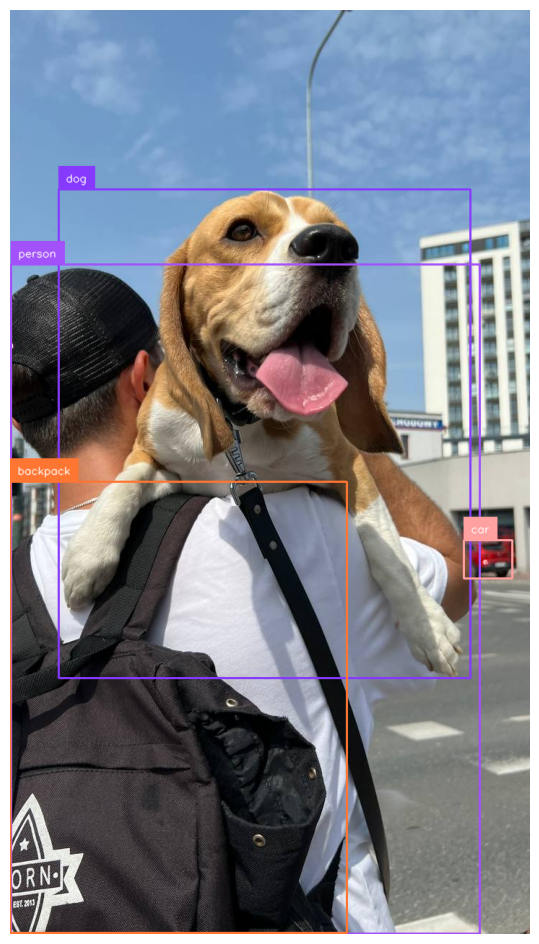

In [24]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [25]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/parkingspots-mos31/parking-spaces-owclt/dataset/2", 'yolov8')

loading Roboflow workspace...
loading Roboflow project...


In [26]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [27]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [28]:
!cat {dataset.location}/data.yaml

names:
- empty
- occupied
nc: 2
roboflow:
  license: CC BY 4.0
  project: parking-spaces-owclt
  url: https://universe.roboflow.com/parkingspots-mos31/parking-spaces-owclt/dataset/2
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [29]:
from ultralytics import YOLO

model = YOLO('yolov12n.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=200)

New https://pypi.org/project/ultralytics/8.3.168 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12n.yaml, data=/content/Parking-Spaces-2/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fals

train: Scanning /content/Parking-Spaces-2/train/labels.cache... 173 images, 0 backgrounds, 0 corrupt: 100%|██████████| 173/173 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1731, len(boxes) = 4629. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Parking-Spaces-2/valid/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 343, len(boxes) = 671. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train7
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      15.6G      4.546      3.964      4.298        423        640: 100%|██████████| 11/11 [00:06<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         24        671    0.00765     0.0697     0.0049    0.00215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200       4.7G      4.491      3.923      4.229        648        640: 100%|██████████| 11/11 [00:06<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         24        671    0.00855     0.0786    0.00475    0.00197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      4.24G      4.377      3.804      4.113        743        640: 100%|██████████| 11/11 [00:04<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         24        671    0.00652     0.0682    0.00404    0.00169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      4.25G       4.06      3.572      3.938        806        640: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24        671    0.00633     0.0667    0.00372    0.00146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      4.96G      3.818       3.34      3.736        544        640: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         24        671    0.00687     0.0712    0.00475    0.00166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      4.33G      3.696      3.119      3.551        621        640: 100%|██████████| 11/11 [00:05<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24        671    0.00629     0.0678    0.00369    0.00138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      4.53G       3.56      2.934      3.382        627        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         24        671    0.00571     0.0633    0.00379    0.00112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      4.09G      3.457      2.825      3.257        843        640: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         24        671    0.00567     0.0492    0.00348   0.000735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      4.25G       3.43      2.754      3.242        629        640: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         24        671    0.00469      0.045    0.00271   0.000725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      4.52G      3.259      2.531      2.965        648        640: 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         24        671    0.00554     0.0603    0.00326   0.000745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      4.46G      3.121      2.452      2.924        624        640: 100%|██████████| 11/11 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         24        671    0.00499     0.0508    0.00282   0.000716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      4.72G      3.001      2.367      2.807        924        640: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         24        671     0.0146      0.174     0.0299    0.00743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      4.59G      2.899      2.275      2.749        887        640: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         24        671     0.0232      0.266     0.0354    0.00962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      4.14G      2.826      2.173      2.657        679        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        671       0.11      0.139     0.0723     0.0215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      4.15G      2.647      2.063      2.547        530        640: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         24        671      0.159       0.11      0.112     0.0364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      4.46G      2.689      2.041      2.454        681        640: 100%|██████████| 11/11 [00:04<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         24        671      0.116      0.294     0.0891     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.43G      2.579      1.985      2.407        541        640: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         24        671       0.14       0.31     0.0893     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.35G      2.522      2.017       2.46        441        640: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         24        671      0.154      0.261     0.0883     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.66G      2.496      1.893       2.36        699        640: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         24        671      0.175      0.328      0.108     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      4.36G      2.423      1.851      2.271        586        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24        671      0.209      0.273      0.162     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.45G      2.275      1.704      2.144        585        640: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         24        671       0.17      0.268      0.119     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200       4.1G      2.271      1.784       2.19        510        640: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         24        671      0.192      0.324      0.129     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.09G      2.271      1.815      2.224        648        640: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         24        671      0.324      0.274      0.223     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.18G      2.153       1.62      2.103        570        640: 100%|██████████| 11/11 [00:04<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         24        671      0.258      0.318      0.215      0.087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.56G      2.201      1.726      2.122        566        640: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         24        671      0.316      0.345       0.26      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      5.08G      2.102      1.604      2.013        603        640: 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         24        671      0.296      0.316      0.231     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.34G      2.118      1.612       2.05        705        640: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         24        671      0.252      0.278      0.206     0.0911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.26G      2.065      1.587      2.021        651        640: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         24        671      0.329      0.378      0.269      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.25G      2.099      1.579      2.004        633        640: 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         24        671       0.36      0.442      0.328       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.41G      2.023      1.593      2.044        493        640: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         24        671      0.444      0.411      0.339      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.52G      1.986      1.541       1.95        564        640: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         24        671      0.393       0.43      0.332      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.79G      2.032       1.54      1.973        505        640: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         24        671       0.34      0.379      0.299       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.33G      2.024      1.568      1.989        438        640: 100%|██████████| 11/11 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         24        671      0.278       0.31      0.221     0.0914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.35G      1.981      1.526       1.95        691        640: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         24        671      0.339      0.392      0.295      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.06G       1.95       1.47      1.922        658        640: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         24        671      0.366      0.428      0.305      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.41G      1.909      1.443       1.89        394        640: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         24        671      0.435       0.46      0.365      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.57G      1.935      1.464      1.932        605        640: 100%|██████████| 11/11 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         24        671      0.453      0.445      0.372      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       4.6G      1.872      1.413       1.81        503        640: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         24        671      0.392      0.453      0.351      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      4.06G      1.853      1.466      1.897        567        640: 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         24        671      0.427      0.433      0.357      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.09G      1.849      1.424      1.827        506        640: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         24        671      0.466      0.444      0.365      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.65G      1.849      1.376      1.814        556        640: 100%|██████████| 11/11 [00:04<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         24        671      0.452      0.459      0.372      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200       4.3G      1.864       1.37        1.8        622        640: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         24        671      0.442      0.474       0.37      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      4.38G       1.84      1.404      1.816        495        640: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         24        671      0.453      0.427       0.38      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.27G      1.801       1.39       1.81        478        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         24        671      0.448      0.467      0.402      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.45G      1.765      1.361      1.789        531        640: 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         24        671      0.451      0.487      0.418      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.63G      1.749      1.322      1.728        656        640: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         24        671      0.455      0.431        0.4      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      4.26G      1.778      1.365      1.807        507        640: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         24        671      0.465      0.489      0.435      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      4.53G      1.794      1.384      1.802        412        640: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         24        671      0.473      0.478       0.42      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.07G      1.768      1.324      1.772        806        640: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         24        671      0.447      0.497      0.407      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      4.04G      1.799       1.37      1.772        604        640: 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         24        671      0.433      0.486      0.406      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200       4.5G      1.713      1.326      1.741        678        640: 100%|██████████| 11/11 [00:05<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         24        671       0.46      0.514       0.42      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      4.52G      1.719      1.288       1.68        655        640: 100%|██████████| 11/11 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         24        671      0.496      0.465       0.41      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      5.22G      1.719       1.29      1.695        644        640: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         24        671      0.422      0.523      0.411      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      4.72G      1.714      1.308      1.728        568        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24        671      0.483      0.501      0.446      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200       4.5G      1.707      1.316      1.721        490        640: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         24        671      0.453      0.519      0.442      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      4.71G      1.637      1.227      1.637        684        640: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         24        671      0.516      0.513       0.44      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      4.39G      1.655      1.258      1.666        441        640: 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         24        671      0.492      0.517      0.443      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      4.13G       1.73      1.302      1.698        571        640: 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         24        671       0.48      0.525      0.436      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      4.79G      1.661      1.247      1.642        661        640: 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         24        671      0.494      0.497      0.424      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200       4.4G       1.65      1.223      1.656        610        640: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         24        671      0.497      0.515      0.446      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      4.24G       1.59      1.191      1.631        544        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         24        671      0.495      0.518      0.453      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      4.46G      1.597      1.195      1.632        724        640: 100%|██████████| 11/11 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         24        671      0.502      0.507      0.461      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      4.62G      1.644      1.239       1.62        565        640: 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         24        671      0.526      0.485       0.44       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      4.66G      1.607      1.209      1.617        701        640: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         24        671      0.522      0.507      0.464      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200       4.6G      1.573      1.187      1.587        905        640: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         24        671      0.512      0.523      0.463      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      4.96G      1.594      1.179       1.61        573        640: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         24        671      0.528      0.487      0.438      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      4.42G       1.59      1.184      1.599        586        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        671      0.511      0.488      0.442      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      4.27G       1.63      1.185      1.621        524        640: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         24        671      0.479      0.546      0.454      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.62G      1.556       1.19      1.577        611        640: 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         24        671      0.538      0.544      0.486      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200       4.8G      1.584      1.179      1.579        483        640: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         24        671      0.549      0.512      0.479      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.08G       1.55      1.148      1.573        659        640: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         24        671      0.554      0.483      0.455      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      4.33G      1.539      1.154      1.583        615        640: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         24        671      0.578       0.52      0.469      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.33G      1.604      1.208      1.659        800        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         24        671      0.561      0.532      0.485        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      4.45G      1.585      1.185      1.604        649        640: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         24        671      0.558      0.527      0.468      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.32G      1.578       1.19      1.589        730        640: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         24        671      0.584       0.51      0.468      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.12G      1.493      1.113       1.53        568        640: 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         24        671      0.562       0.55      0.479      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.16G      1.432      1.063      1.505        579        640: 100%|██████████| 11/11 [00:04<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         24        671       0.54      0.527      0.474      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200       4.7G      1.533      1.107      1.545        651        640: 100%|██████████| 11/11 [00:04<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         24        671      0.541      0.526      0.476      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.67G      1.551      1.192      1.602        564        640: 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         24        671      0.569      0.505      0.475      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      4.11G       1.48      1.097      1.528        425        640: 100%|██████████| 11/11 [00:04<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         24        671      0.572      0.519       0.48      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      4.28G      1.524      1.186      1.592        411        640: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         24        671       0.55      0.544      0.495      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      4.49G      1.526       1.14      1.547        709        640: 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         24        671       0.54      0.521      0.492      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.02G      1.494      1.151      1.553        748        640: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         24        671      0.582      0.516      0.491      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200       4.2G      1.493      1.123      1.539        714        640: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         24        671       0.55      0.558      0.475      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.52G      1.448      1.076      1.518        745        640: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         24        671      0.561      0.561      0.483      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200         4G      1.478      1.136      1.548        831        640: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         24        671      0.541      0.564      0.491      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.24G       1.44      1.092      1.517        695        640: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         24        671      0.494      0.573      0.487      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.38G      1.489      1.117      1.533        707        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         24        671      0.536      0.589      0.502      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.43G      1.482      1.097      1.491        772        640: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         24        671      0.573      0.579      0.508      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.58G      1.453      1.078      1.513        523        640: 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         24        671      0.569      0.591      0.515      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      4.81G      1.423      1.073      1.488        512        640: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         24        671      0.577      0.555      0.487      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.15G      1.474      1.095      1.514        627        640: 100%|██████████| 11/11 [00:04<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         24        671      0.566      0.574      0.503      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.56G      1.461      1.104      1.502        520        640: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         24        671      0.564      0.555      0.506      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.81G      1.457      1.082      1.493        523        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         24        671      0.588      0.581      0.526      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       4.4G      1.411       1.02      1.448        558        640: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         24        671      0.576      0.566      0.512      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.87G      1.387      1.013      1.467        546        640: 100%|██████████| 11/11 [00:04<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         24        671       0.55      0.591      0.502      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200       4.6G      1.374      1.023      1.431        706        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        671      0.575      0.574      0.516      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.57G      1.368      1.008       1.45        553        640: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         24        671      0.595      0.581      0.528      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200       4.3G      1.391      1.036      1.458        721        640: 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         24        671      0.582       0.61      0.546      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       4.3G       1.34     0.9954      1.429        731        640: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         24        671      0.556      0.589      0.526      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.33G       1.35      1.012      1.448        574        640: 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         24        671      0.601      0.599      0.541      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.44G      1.306     0.9832      1.396        666        640: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         24        671      0.593       0.62      0.542      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.55G      1.351      1.013      1.409        662        640: 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         24        671      0.573      0.582      0.515      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.53G      1.348     0.9853       1.41        606        640: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         24        671       0.55      0.598      0.509      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.63G      1.352      1.022      1.433        460        640: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         24        671      0.557      0.587      0.519      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.35G      1.301     0.9458      1.373        516        640: 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         24        671      0.572      0.572      0.523      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.34G      1.421      1.035      1.495        862        640: 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         24        671      0.568      0.625       0.53      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.06G      1.407      1.035      1.485        452        640: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         24        671      0.586      0.576      0.517      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.16G      1.384      1.032      1.448        604        640: 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         24        671       0.59       0.61      0.538      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      4.28G      1.335     0.9766      1.409        520        640: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         24        671      0.587       0.61      0.544      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.44G      1.272     0.9953       1.41        490        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         24        671      0.581      0.618      0.551      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200       4.3G      1.342      1.013       1.43        842        640: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         24        671      0.574      0.596      0.549      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.01G      1.382      1.004      1.475        615        640: 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         24        671       0.55      0.608      0.533      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      4.53G      1.326     0.9943      1.428        478        640: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         24        671       0.58       0.56       0.52      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.32G      1.356      1.002      1.426        779        640: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         24        671      0.587      0.619      0.551      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.67G      1.224     0.9442      1.349        442        640: 100%|██████████| 11/11 [00:04<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         24        671      0.607      0.626      0.562      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      5.01G      1.391       1.04       1.45        542        640: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         24        671      0.607      0.626       0.56      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.37G      1.332      1.015      1.423        565        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         24        671      0.587      0.603      0.552      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200       4.6G      1.402      1.069      1.463        758        640: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        671      0.569      0.604       0.54      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      4.43G      1.359      1.026      1.465        483        640: 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         24        671      0.609      0.642      0.576      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.05G      1.315     0.9904      1.423        467        640: 100%|██████████| 11/11 [00:05<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         24        671      0.588      0.624      0.568       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.19G      1.263     0.9743      1.396        486        640: 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         24        671      0.593      0.594      0.546      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      4.23G       1.31      1.003      1.402        721        640: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         24        671      0.606      0.631       0.57      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      4.23G       1.33      1.004      1.412        547        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         24        671      0.604      0.633      0.574      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      4.15G      1.326     0.9775      1.399        526        640: 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         24        671      0.595      0.646      0.577       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      3.92G      1.277     0.9582      1.412        444        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         24        671      0.613      0.633      0.574       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      4.03G      1.279     0.9522      1.387        618        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         24        671      0.607      0.644      0.567      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      4.43G      1.278     0.9743      1.391        481        640: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         24        671      0.613      0.645      0.571      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      4.25G      1.232     0.9201      1.341        733        640: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         24        671      0.596       0.65      0.573      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      4.63G      1.353      1.024      1.434        475        640: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         24        671      0.621       0.63      0.579      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      4.65G      1.271     0.9401      1.364        705        640: 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         24        671      0.601      0.649      0.578      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      4.46G      1.246     0.9418      1.365        505        640: 100%|██████████| 11/11 [00:05<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         24        671      0.595      0.619      0.567      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      4.37G       1.24      0.946      1.365        749        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         24        671      0.581      0.627      0.568      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      4.73G      1.195     0.9072      1.319        493        640: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        671      0.582      0.649      0.576      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      4.54G      1.264     0.9192      1.354        678        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        671      0.575      0.658      0.569      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      4.76G      1.247     0.9178      1.339        517        640: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         24        671      0.612      0.649      0.585      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      4.67G      1.177     0.9049      1.311        518        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         24        671      0.615      0.636      0.582      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.35G      1.205     0.8772      1.322        959        640: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         24        671       0.59      0.637      0.575      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      4.66G      1.241     0.9287      1.365        713        640: 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         24        671      0.588      0.643       0.58      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      4.32G      1.203     0.9348      1.358        705        640: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         24        671      0.625      0.642      0.591      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      4.05G      1.267      0.926       1.38        485        640: 100%|██████████| 11/11 [00:04<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         24        671      0.616      0.654      0.589      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      4.13G      1.197     0.9126      1.363        761        640: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         24        671      0.614      0.646      0.586      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      4.32G       1.29     0.9808      1.383        654        640: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         24        671      0.624      0.627      0.593      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      4.71G      1.189     0.9124      1.329        481        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         24        671      0.634      0.604       0.59      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      4.53G      1.126     0.8417      1.284        597        640: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         24        671       0.61      0.645      0.603      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      4.59G      1.212     0.8954      1.341        566        640: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         24        671      0.623      0.661       0.61      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      4.88G       1.18     0.8895       1.33        820        640: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         24        671      0.599      0.668      0.599      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200       4.2G      1.152     0.8618      1.312        558        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         24        671       0.63      0.652      0.609      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      4.62G      1.194      0.901       1.33        594        640: 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         24        671      0.628      0.664      0.607      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      4.84G      1.179     0.8735      1.332        538        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         24        671      0.597       0.65      0.593      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      4.21G      1.222     0.9062      1.332        475        640: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         24        671       0.63      0.633      0.592      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      4.43G      1.233     0.9251      1.355        700        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         24        671      0.634      0.644      0.604      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      3.98G       1.26     0.9382      1.371        647        640: 100%|██████████| 11/11 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         24        671      0.631      0.641      0.605      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      4.81G      1.156     0.8897      1.312        595        640: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        671      0.617      0.642      0.603       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      4.03G      1.245     0.9386      1.351        403        640: 100%|██████████| 11/11 [00:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         24        671      0.614      0.658        0.6      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      4.23G      1.213      0.907      1.332        754        640: 100%|██████████| 11/11 [00:04<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         24        671      0.603      0.645       0.59       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      4.79G      1.204     0.8732        1.3        595        640: 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         24        671       0.61      0.658      0.595      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      4.27G        1.2     0.9012      1.336        629        640: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         24        671       0.62       0.66      0.599      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      3.89G      1.191     0.8904      1.334        787        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         24        671      0.619      0.669      0.598      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      4.25G      1.168     0.8607        1.3        446        640: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         24        671      0.625      0.664      0.599      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200       4.5G      1.236     0.9346      1.364        693        640: 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         24        671      0.633      0.669      0.606      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      4.56G      1.209     0.8979      1.331        530        640: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         24        671      0.643      0.651      0.617      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      4.51G      1.268     0.9597      1.372        764        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         24        671       0.61       0.64      0.604      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      4.09G      1.179     0.8619      1.304        624        640: 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         24        671      0.623      0.636      0.599      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      4.22G      1.204      0.903      1.338        353        640: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         24        671      0.638      0.648      0.615      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      4.94G      1.193     0.8752       1.33        462        640: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         24        671      0.639      0.682      0.625      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      4.29G      1.144     0.8726        1.3        633        640: 100%|██████████| 11/11 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         24        671      0.615      0.682      0.619      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      4.51G      1.179     0.8791      1.331        585        640: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         24        671      0.628      0.648      0.616      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      4.75G      1.179     0.9175      1.326        472        640: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         24        671      0.619      0.675      0.618       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      4.38G      1.147     0.8547      1.286        651        640: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         24        671      0.621      0.665      0.616      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      4.15G      1.154     0.8603        1.3        659        640: 100%|██████████| 11/11 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         24        671      0.605      0.685       0.61      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      4.11G      1.158     0.8585      1.295        689        640: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         24        671      0.612      0.683      0.612      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      4.23G       1.12      0.849      1.271        673        640: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         24        671      0.627       0.67      0.619      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      5.14G      1.267     0.9434      1.373        549        640: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         24        671      0.645      0.671      0.622      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200       4.8G       1.18     0.8815      1.344        443        640: 100%|██████████| 11/11 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         24        671      0.629      0.675      0.617       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      4.72G       1.12     0.8526      1.292        600        640: 100%|██████████| 11/11 [00:04<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         24        671      0.643      0.664      0.617      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      4.93G       1.22     0.8992      1.344        657        640: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         24        671      0.639      0.671      0.621      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      4.63G      1.139     0.8526      1.275        461        640: 100%|██████████| 11/11 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         24        671       0.63      0.668      0.625      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      4.22G      1.177      0.863      1.337        528        640: 100%|██████████| 11/11 [00:04<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         24        671      0.622      0.671      0.625      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      5.08G      1.168     0.8753      1.304        476        640: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         24        671      0.618      0.696      0.625      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      5.16G      1.161      0.865      1.303        621        640: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        671      0.626      0.681      0.622      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      4.23G      1.139     0.8525      1.291        492        640: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         24        671      0.625        0.7      0.624      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      4.21G      1.113     0.8398      1.284        520        640: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         24        671      0.628      0.687      0.625       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      4.66G      1.148     0.8663      1.311        670        640: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         24        671      0.619      0.681      0.623      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      4.66G      1.217     0.8777      1.315        698        640: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         24        671      0.625      0.681      0.622      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      4.14G       1.16     0.8887      1.309        562        640: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         24        671      0.622      0.681      0.618      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      4.75G      1.137     0.8574      1.285        764        640: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         24        671      0.622      0.681       0.62      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      4.45G      1.196     0.8711      1.337        447        640: 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         24        671       0.62      0.682      0.627      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      4.32G      1.151     0.8439      1.301        878        640: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         24        671      0.617      0.694      0.633       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      4.24G      1.188     0.8779      1.353        630        640: 100%|██████████| 11/11 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         24        671       0.61      0.701      0.632      0.446


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.85G      1.197      1.078      1.382        322        640: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         24        671        0.6      0.687      0.614      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.86G      1.121     0.9656      1.311        502        640: 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         24        671      0.618      0.658      0.609       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      3.89G      1.154     0.9627      1.364        288        640: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         24        671       0.63      0.652       0.61       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      3.89G      1.151     0.9738      1.365        280        640: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         24        671      0.625      0.655      0.612      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      3.89G       1.13     0.9658      1.355        395        640: 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         24        671      0.611      0.669      0.613       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      3.92G      1.108     0.9379      1.354        349        640: 100%|██████████| 11/11 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         24        671      0.602      0.663      0.608      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200       3.8G      1.126     0.9188      1.348        393        640: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         24        671      0.602      0.664      0.605      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      3.86G      1.102      0.931      1.359        354        640: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         24        671      0.607      0.666      0.611      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      3.78G      1.038     0.8716      1.286        330        640: 100%|██████████| 11/11 [00:04<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         24        671      0.616      0.684      0.614      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200       3.9G      1.054     0.8802      1.292        236        640: 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         24        671      0.619      0.683      0.617      0.438



200 epochs completed in 0.338 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 5.5MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 376 layers, 2,508,734 parameters, 0 gradients, 5.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


                   all         24        671      0.618      0.695      0.633      0.451
                 empty         23        324      0.583      0.593      0.529      0.368
              occupied         23        347      0.653      0.797      0.737      0.533
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train7


## Evaluate fine-tuned YOLOv12 model

In [35]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch0.jpg
events.out.tfevents.1752907731.6bc1213b4699.3679.0  train_batch1.jpg
labels_correlogram.jpg				    train_batch2.jpg
labels.jpg					    weights
results.csv


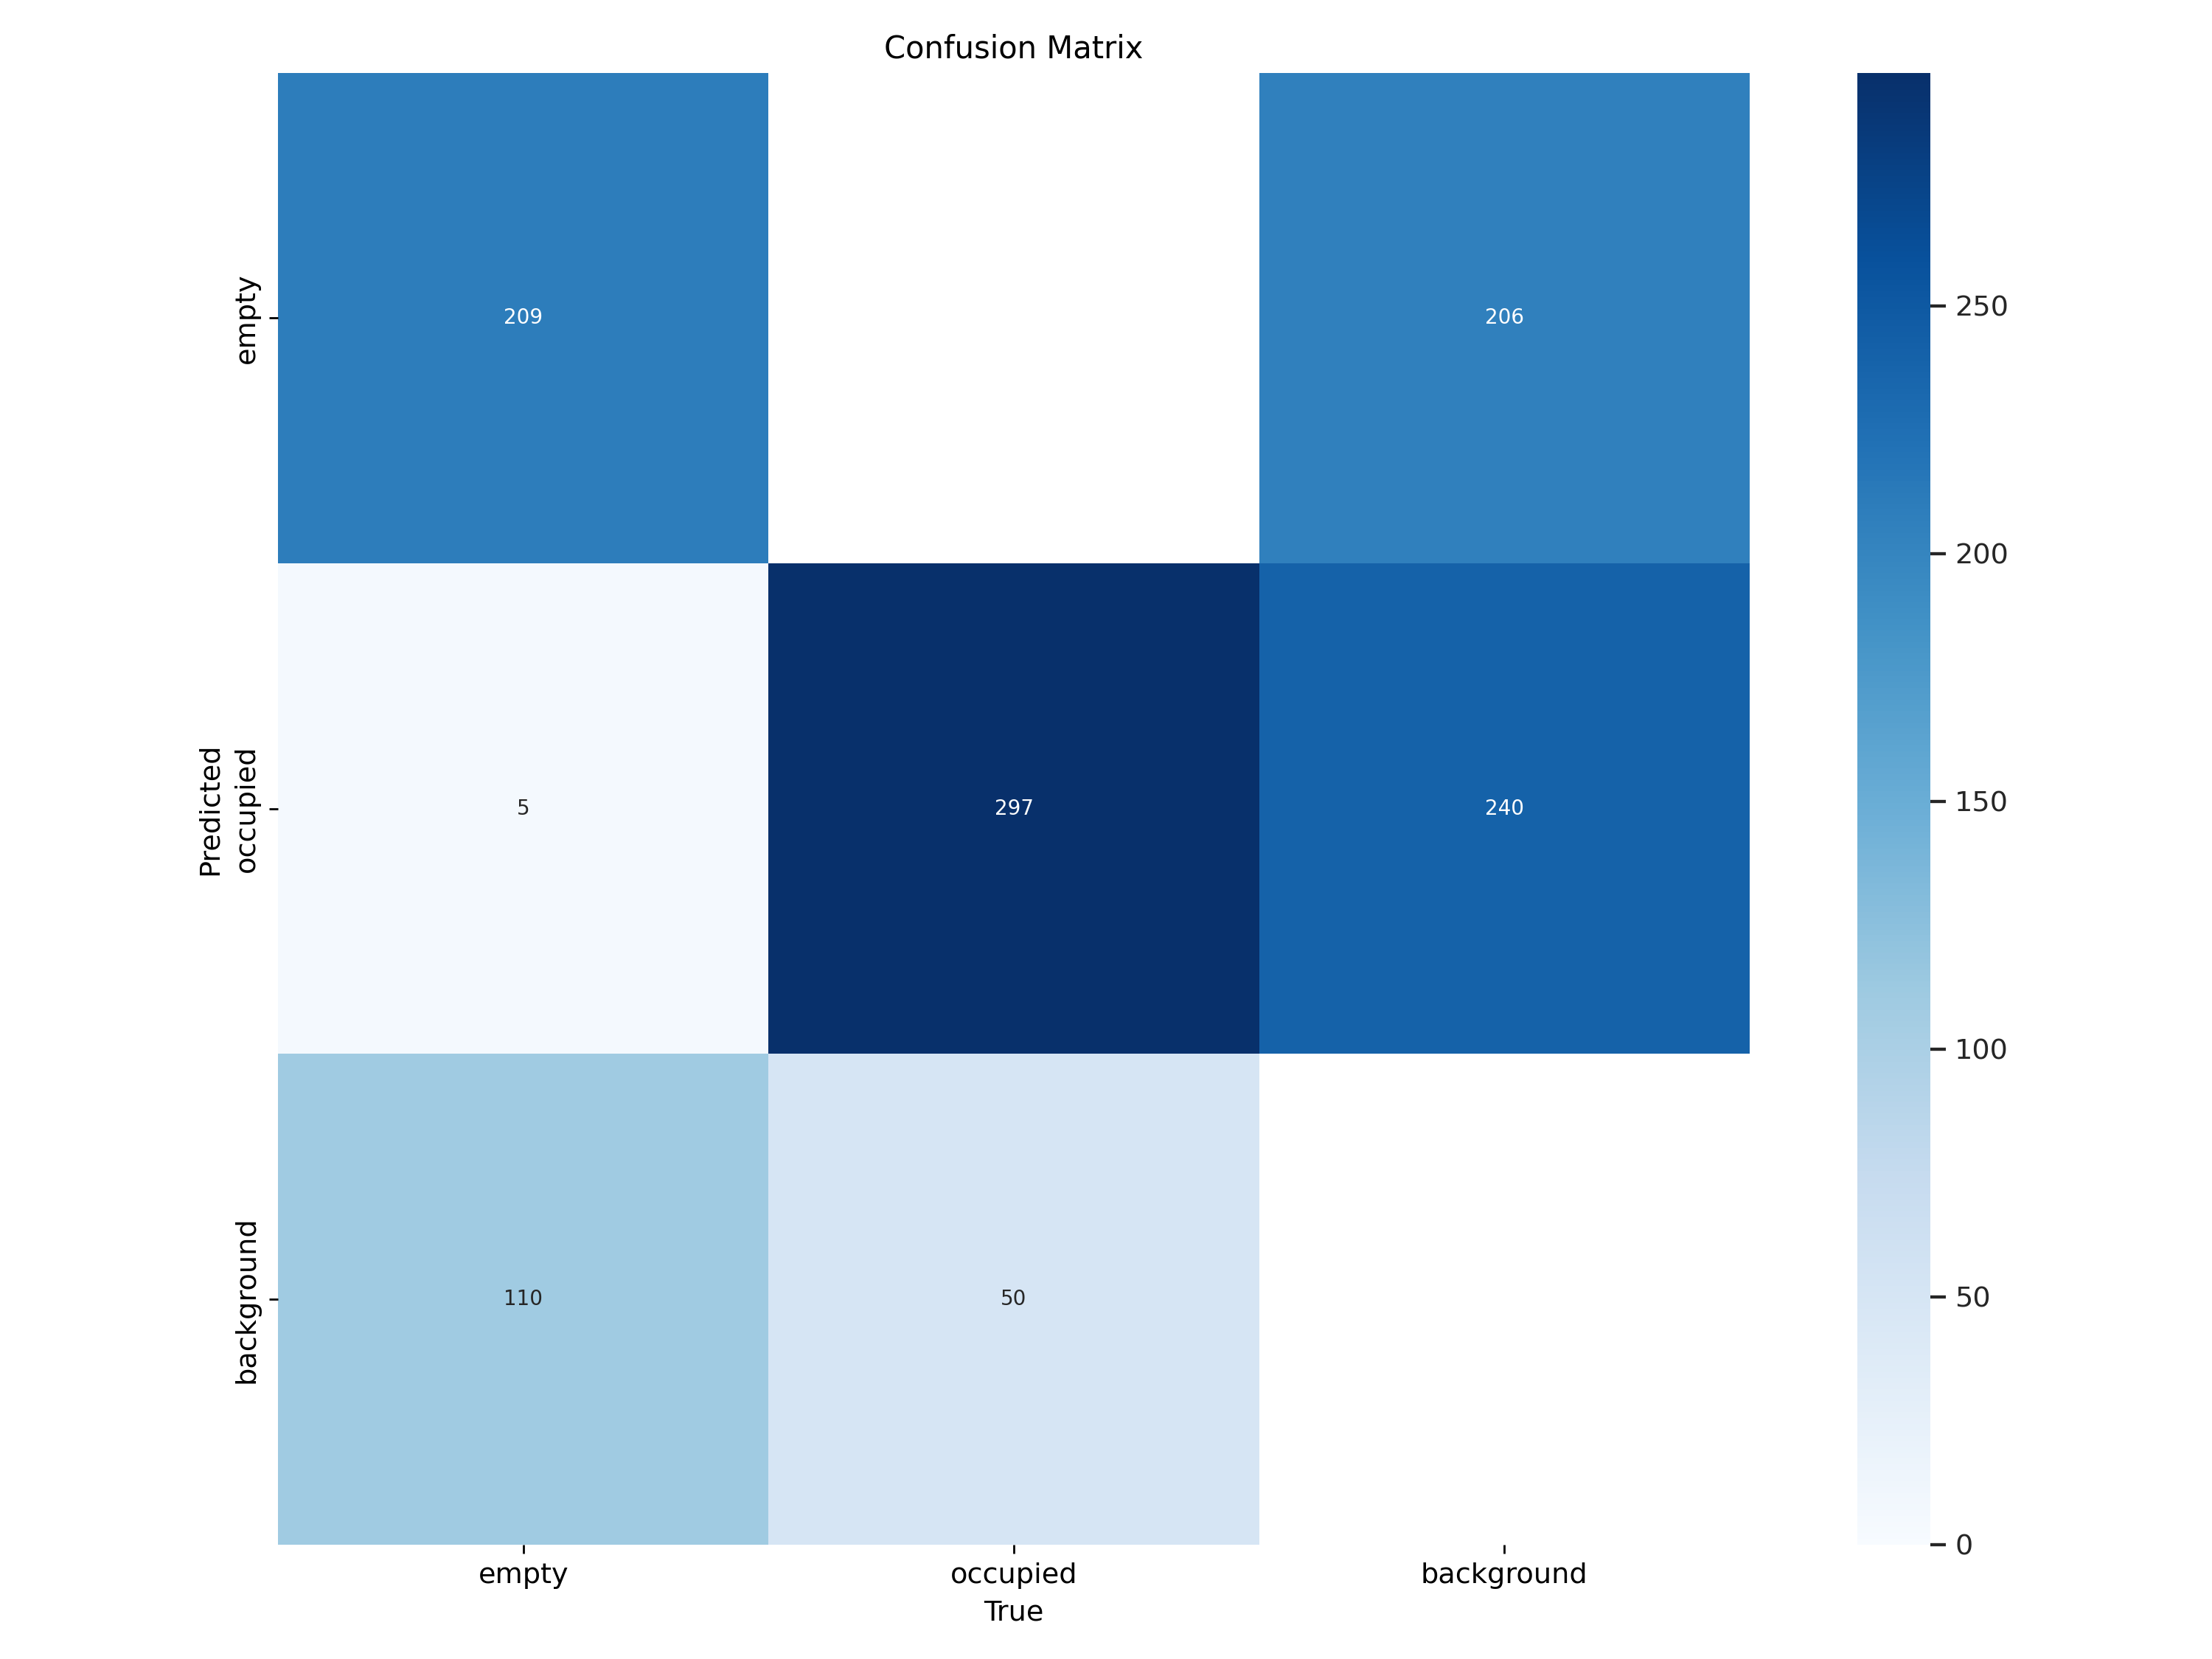

In [36]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train7/confusion_matrix.png', width=1000)

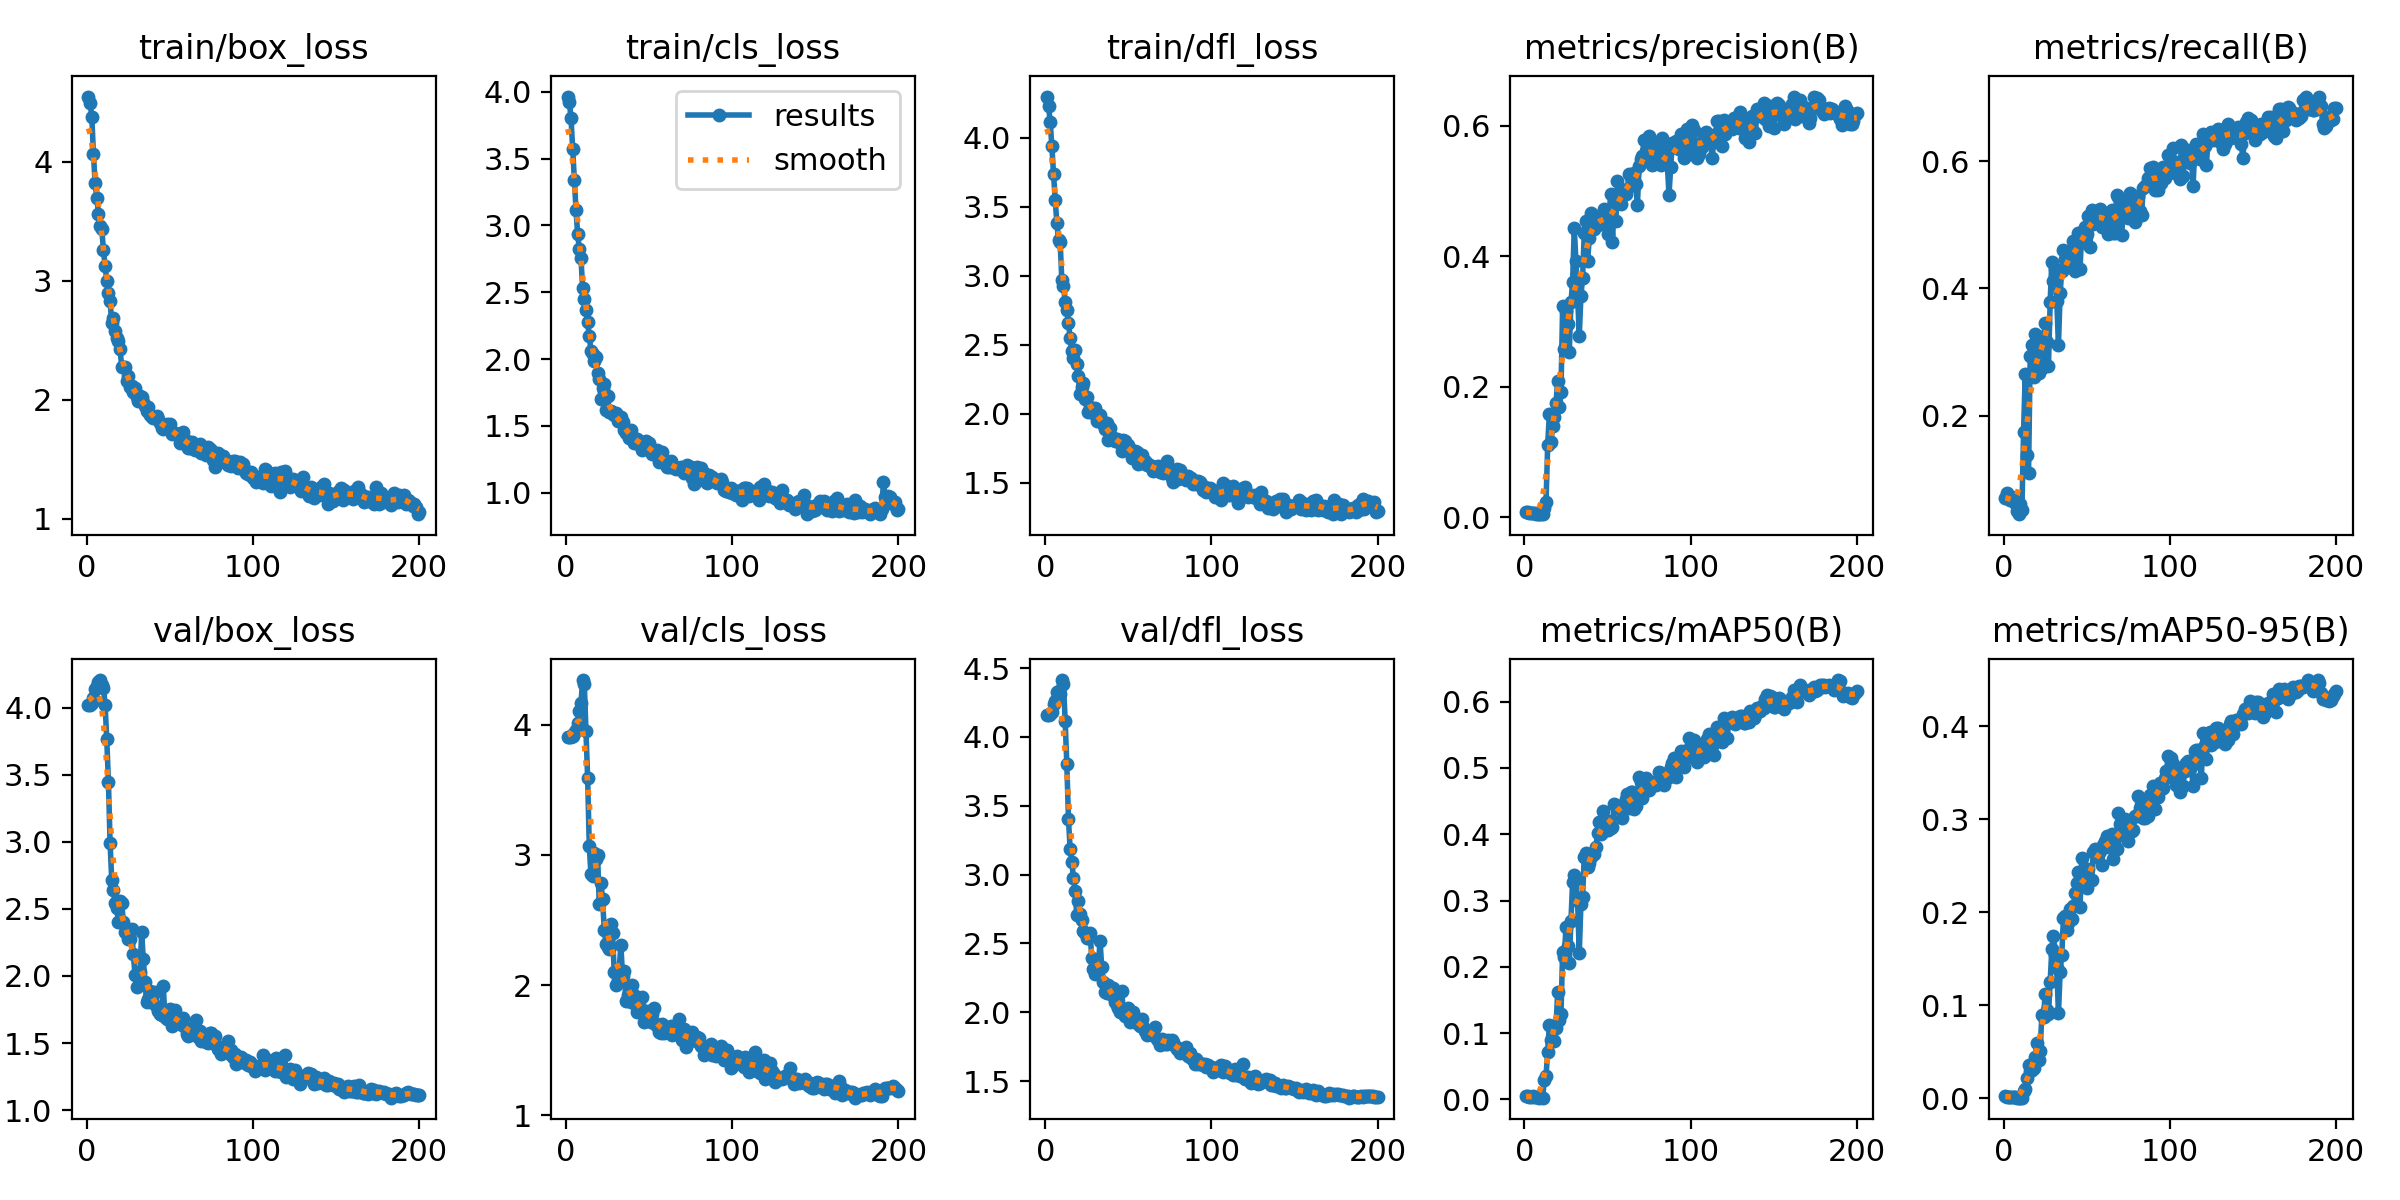

In [38]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train7/results.png', width=1000)

In [39]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['empty', 'occupied']

In [41]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train7/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [42]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6604641733692491
mAP 50 0.8640470086101842
mAP 75 0.7512168459237047


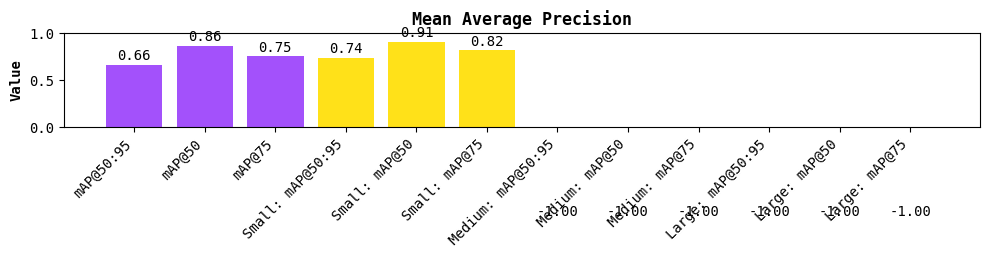

In [43]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [45]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train7/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

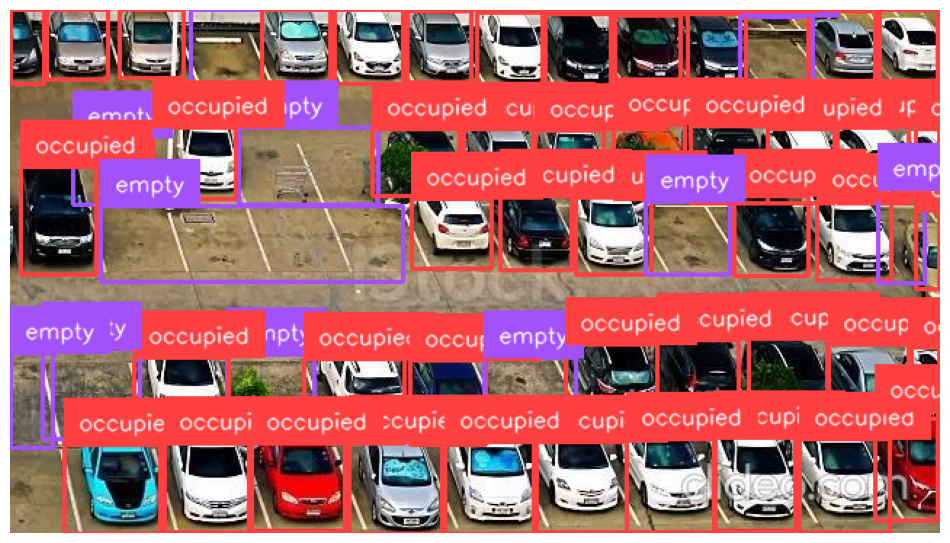

In [46]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)